In [1]:
# Mattia Vaccari - http://www.mattiavaccari.net - https://github.com/mattia-vaccari
# IDIA/ilifu - https://idia.ac.za - https://www.ilifu.ac.za - https://github.com/idia-astro

In [2]:
# SciServer @ JHU IDIES
# Web Site - https://www.sciserver.org - https://idies.jhu.edu
# GitHub https://github.com/sciserver
# Stand-Alone Client - https://github.com/sciserver/SciScript-Python
# Example Notebooks - https://github.com/sciserver/Example-Notebooks    

In [2]:
# Authentication

from SciServer import Authentication

#username = '***'
#password = '***'
#login = Authentication.login(username,password)

login = Authentication.login()

token = Authentication.getToken()

Enter SciServer user name:  ········
Enter SciServer password:  ········


In [3]:
# Imports

from io import StringIO
from io import BytesIO

import astropy.io.fits as pf
import numpy as np
import pandas as pd

import itertools
import timeit

from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.metrics import accuracy_score as acc
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from SciServer import CasJobs

In [13]:
# Run SciServer Query for Classification Experiment

NOBJECTS = 100000

# Bright Limits : Somewhat Arbitrary
# Faint Limits : Median 5-sigma depths from
# https://www.sdss.org/dr16/imaging/other_info/#DepthsoftheSDSSphotometricsurvey

query_text = ('\n'.join(
    ("SELECT TOP %i" % NOBJECTS,
    "   p.u, p.g, p.r, p.i, p.z, s.class, s.subclass, s.z as redshift, s.zerr as redshift_error, s.zwarning as redshift_warning, w.w1mpro as w1, w.w2mpro as w2",
    "FROM PhotoObj AS p",
    "   JOIN SpecObj AS s ON s.bestobjid = p.objid",
    "   JOIN wise_xmatch AS x ON x.sdss_objid = p.objid",
    "   JOIN wise_allsky AS w ON w.cntr = x.wise_cntr",
    "WHERE ",
    "       p.u BETWEEN 13.0 AND 22.15",
    "   AND p.g BETWEEN 13.0 AND 23.13",
    "   AND p.r BETWEEN 13.0 AND 22.70",
    "   AND p.i BETWEEN 13.0 AND 22.20",
    "   AND p.z BETWEEN 13.0 AND 20.71",
    "   AND p.mode = 1 AND p.clean = 1 AND s.zwarning = 0",
    "   AND (s.class = 'STAR' OR s.class = 'GALAXY' OR s.class = 'QSO')")))

df = CasJobs.getPandasDataFrameFromQuery(query_text, "DR18")
 
df

,u,g,r,i,z,class,subclass,redshift,redshift_error,redshift_warning,w1,w2
0,18.53054,17.41920,17.05508,16.92661,16.86643,STAR,F3/F5V (30743),-0.000048,0.000009,0,15.829,15.646
1,20.01205,18.12893,17.10455,16.66273,16.35428,GALAXY,BROADLINE,0.173871,0.000018,0,13.832,13.560
2,19.85333,17.90028,16.82985,16.34828,15.96488,GALAXY,NaN,0.111662,0.000027,0,13.680,13.535
3,21.21593,21.03118,20.83324,20.51451,20.41760,QSO,BROADLINE,2.046120,0.000612,0,16.757,15.686
4,20.11000,18.26992,17.29160,16.86374,16.49716,GALAXY,NaN,0.086365,0.000025,0,14.146,14.044
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,21.49871,21.11473,20.94678,20.53103,20.45057,QSO,BROADLINE,1.705606,0.001173,0,17.194,16.004
99996,20.59337,18.99870,18.29813,18.02987,17.90899,STAR,K1,-0.000037,0.000011,0,16.149,15.993
99997,19.64988,17.76075,16.96775,16.65490,16.47753,STAR,K3,-0.000195,0.000008,0,14.796,14.963
99998,19.75069,18.67944,18.22202,17.97755,17.89881,STAR,F5,-0.000764,0.000020,0,16.484,16.833


In [14]:
# Extract Data

u = df['u']
g = df['g']
r = df['r']
i = df['i']
z = df['z']
w1 = df['w1']
w2 = df['w2']

class_in = df['class']
subclass_in = df['subclass']
redshift=df['redshift']

class_in

0          STAR
1        GALAXY
2        GALAXY
3           QSO
4        GALAXY
          ...  
99995       QSO
99996      STAR
99997      STAR
99998      STAR
99999      STAR
Name: class, Length: 100000, dtype: object

In [15]:
# Source Classification - Assemble Data

x = np.vstack([np.array(r), np.array(u) - np.array(g), np.array(g) - np.array(r), np.array(r) - np.array(i), np.array(i) - np.array(z), np.array(z) - np.array(w1), np.array(w1) - np.array(w2)]).T

y, c = pd.factorize(class_in)

indices = np.arange(x.shape[0])

x_train, x_test, y_train, y_test, i_train, i_test = train_test_split(x, y, indices, test_size=0.20)

c

Index(['STAR', 'GALAXY', 'QSO'], dtype='object')

In [16]:
# Source Classification - Run kNN Classifier

y_predict = []

start_time = timeit.default_timer()

n_neighbors = 10

ks = KNeighborsClassifier(n_neighbors)
ks.fit(x_train, y_train)  
y_ks = ks.predict(x_test)
elapsed = timeit.default_timer() - start_time
proba = ks.predict_proba(x_test)
y_predict.append(y_ks)
acu = acc(y_test, y_ks)

print('Elapsed time for knn: {} seconds'.format(elapsed))
print(len(y_ks))
print('Accuracy for kNN for k={:} is: {}'.format(n_neighbors,acu))
print(metrics.classification_report(y_test, y_ks, target_names=c, digits=4))

Elapsed time for knn: 1.5998923960141838 seconds
20000
Accuracy for kNN for k=10 is: 0.968
              precision    recall  f1-score   support

        STAR     0.9547    0.9578    0.9562      5166
      GALAXY     0.9726    0.9711    0.9719     10803
         QSO     0.9727    0.9727    0.9727      4031

    accuracy                         0.9680     20000
   macro avg     0.9667    0.9672    0.9669     20000
weighted avg     0.9680    0.9680    0.9680     20000



In [19]:
# Phot-Z Estimate - SFGs - Data Query

NOBJECTS = 100000

query_text = ('\n'.join(
    ("SELECT TOP %i" % NOBJECTS,
    "   p.u, p.g, p.r, p.i, p.z, s.class, s.subclass, s.z as redshift, s.zerr as redshift_error, s.zwarning as redshift_warning, w.w1mpro as w1, w.w2mpro as w2",
    "FROM PhotoObj AS p",
    "   JOIN SpecObj AS s ON s.bestobjid = p.objid",
    "   JOIN wise_xmatch AS x ON x.sdss_objid = p.objid",
    "   JOIN wise_allsky AS w ON w.cntr = x.wise_cntr",
    "WHERE",
    "       p.u BETWEEN 13.0 AND 22.15",
    "   AND p.g BETWEEN 13.0 AND 23.13",
    "   AND p.r BETWEEN 13.0 AND 22.70",
    "   AND p.i BETWEEN 13.0 AND 22.20",
    "   AND p.z BETWEEN 13.0 AND 20.71",
    "   AND p.mode = 1 AND p.clean = 1 AND s.zwarning = 0",
    "   AND s.class = 'GALAXY'")))

df = CasJobs.getPandasDataFrameFromQuery(query_text, "DR18")
 
df

,u,g,r,i,z,class,subclass,redshift,redshift_error,redshift_warning,w1,w2
0,19.58530,17.40534,16.44847,16.02291,15.66691,GALAXY,NaN,0.076432,0.000013,0,13.363,13.344
1,20.96586,19.56280,18.86227,18.45869,18.21862,GALAXY,STARFORMING,0.082202,0.000007,0,15.834,15.718
2,20.23697,18.40699,17.53669,17.12455,16.82727,GALAXY,NaN,0.074278,0.000022,0,14.447,14.512
3,20.44907,18.36981,17.18420,16.67934,16.31302,GALAXY,NaN,0.152665,0.000026,0,13.666,13.531
4,21.20470,21.83997,20.53758,19.51763,19.33898,GALAXY,NaN,0.552244,0.000365,0,15.817,15.997
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,20.57120,18.70610,17.79983,17.36331,17.00797,GALAXY,NaN,0.082823,0.000039,0,14.676,14.610
99996,19.75933,18.29308,17.28566,16.78044,16.38518,GALAXY,NaN,0.104129,0.000023,0,14.319,14.005
99997,19.75933,18.29308,17.28566,16.78044,16.38518,GALAXY,NaN,0.104129,0.000023,0,14.676,14.590
99998,16.88380,15.29375,14.63041,14.22610,13.91402,GALAXY,STARFORMING,0.032004,0.000008,0,12.748,12.760


In [20]:
# Phot-Z Estimate - SFGs - Data Extraction

u = df['u']
g = df['g']
r = df['r']
i = df['i']
z = df['z']
w1 = df['w1']
w2 = df['w2']

class_in = df['class']
subclass_in = df['subclass']
redshift=df['redshift']

redshift

0        0.076432
1        0.082202
2        0.074278
3        0.152665
4        0.552244
           ...   
99995    0.082823
99996    0.104129
99997    0.104129
99998    0.032004
99999    0.688004
Name: redshift, Length: 100000, dtype: float64

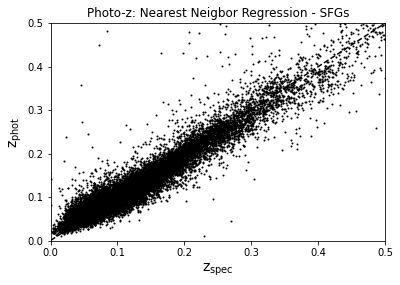

In [21]:
# Phot-Z Estimate - SFGs - kNN Estimate

x = np.vstack([np.array(r), np.array(u) - np.array(g), np.array(g) - np.array(r), np.array(r) - np.array(i), np.array(i) - np.array(z), np.array(z) - np.array(w1), np.array(w1) - np.array(w2)]).T

y = redshift

indices = np.arange(x.shape[0])

x_train, x_test, y_train, y_test, i_train, i_test = train_test_split(x, y, indices, test_size=0.20)

n_neighbors = 10

knn = KNeighborsRegressor(n_neighbors, weights='uniform')

y_pred = knn.fit(x_train,y_train).predict(x_test)

axis_lim = np.array([0.0, 0.5])
ax = plt.axes()
plt.scatter(y_test,y_pred, c='k', lw=0, s=4)
plt.plot(axis_lim, axis_lim, '--k')
plt.xlim(axis_lim)
plt.ylim(axis_lim)
plt.title('Photo-z: Nearest Neigbor Regression - SFGs')
plt.xlabel(r'$\mathrm{z_{spec}}$', fontsize=14)
plt.ylabel(r'$\mathrm{z_{phot}}$', fontsize=14)
plt.show()

In [22]:
# Phot-Z Estimate - SFGs - kNN Performance

ztest=y_test
zpred=y_pred

sfg_del_z=(zpred-ztest)/(1+ztest)
sfg_mean=np.mean((zpred-ztest)/(1+ztest))
sfg_median=np.median((zpred-ztest)/(1+ztest))
sfg_RMS=np.std((zpred-ztest)/(1+ztest))
sfg_MAD=np.median(abs(sfg_del_z-np.median(sfg_del_z)))
sfg_NMAD=1.4826*sfg_MAD

print(sfg_mean,sfg_median,sfg_RMS,sfg_NMAD)

sfg_sig_1 = abs(sfg_del_z) > (1.*sfg_RMS)
sfg_sigma_1 = (float(len(sfg_del_z[sfg_sig_1]))/len(sfg_del_z))*100.

sfg_sig_2 = abs(sfg_del_z) > (2.*sfg_RMS)
sfg_sigma_2 = (float(len(sfg_del_z[sfg_sig_2]))/len(sfg_del_z))*100.

sfg_sig_3 = abs(sfg_del_z) > (3.*sfg_RMS)
sfg_sigma_3 = (float(len(sfg_del_z[sfg_sig_3]))/len(sfg_del_z))*100.

sfg_sig_5 = abs(sfg_del_z) > 0.05
sfg_sigma_5 = (float(len(sfg_del_z[sfg_sig_5]))/len(sfg_del_z))*100.

sfg_sig_10 = abs(sfg_del_z) > 0.10
sfg_sigma_10 = (float(len(sfg_del_z[sfg_sig_10]))/len(sfg_del_z))*100.

sfg_sig_15 = abs(sfg_del_z) > 0.15
sfg_sigma_15 = (float(len(sfg_del_z[sfg_sig_15]))/len(sfg_del_z))*100.

print(sfg_sigma_1,sfg_sigma_2,sfg_sigma_3,sfg_sigma_5,sfg_sigma_10,sfg_sigma_15)

0.0005838474946196319 0.00018773175128827037 0.0262657406309522 0.016427060545953703
16.505 3.2099999999999995 1.145 3.6900000000000004 0.72 0.31


In [23]:
# Phot-Z Estimate - AGNs - Data Query

NOBJECTS = 100000

query_text = ('\n'.join(
    ("SELECT TOP %i" % NOBJECTS,
    "   p.u, p.g, p.r, p.i, p.z, s.class, s.subclass, s.z as redshift, s.zerr as redshift_error, s.zwarning as redshift_warning, w.w1mpro as w1, w.w2mpro as w2",
    "FROM PhotoObj AS p",
    "   JOIN SpecObj AS s ON s.bestobjid = p.objid",
    "   JOIN wise_xmatch AS x ON x.sdss_objid = p.objid",
    "   JOIN wise_allsky AS w ON w.cntr = x.wise_cntr",
    "WHERE ",
    "       p.u BETWEEN 13.0 AND 22.15",
    "   AND p.g BETWEEN 13.0 AND 23.13",
    "   AND p.r BETWEEN 13.0 AND 22.70",
    "   AND p.i BETWEEN 13.0 AND 22.20",
    "   AND p.z BETWEEN 13.0 AND 20.71",
    "   AND p.mode = 1 AND p.clean = 1 AND s.zwarning = 0",
    "   AND s.class = 'QSO'")))

df = CasJobs.getPandasDataFrameFromQuery(query_text, "DR18")
 
df

,u,g,r,i,z,class,subclass,redshift,redshift_error,redshift_warning,w1,w2
0,18.87785,18.74374,18.44886,18.10822,18.15495,QSO,BROADLINE,1.788007,0.000323,0,15.057,13.652
1,18.30134,17.92953,17.88484,17.94083,17.86103,QSO,BROADLINE,0.731879,0.000066,0,14.444,13.219
2,21.74175,21.09306,20.70045,20.46777,20.12977,QSO,BROADLINE,2.271635,0.000828,0,16.218,15.398
3,20.13354,19.37236,19.25973,19.29276,19.01324,QSO,BROADLINE,2.504660,0.000280,0,16.094,14.964
4,21.63369,21.20038,20.98356,20.57153,20.66350,QSO,BROADLINE,1.497144,0.000512,0,16.289,14.903
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,18.29473,18.10370,17.93761,17.68579,17.66269,QSO,BROADLINE,1.588569,0.000162,0,14.508,13.161
99996,19.41365,19.27550,19.03795,19.11155,19.19484,QSO,BROADLINE,1.122347,0.000465,0,15.239,14.156
99997,18.61398,18.39330,18.16899,18.21085,18.11108,QSO,BROADLINE,0.970559,0.000362,0,14.368,13.118
99998,20.76623,20.54385,20.26438,19.95682,19.76522,QSO,STARBURST BROADLINE,0.518502,0.000070,0,15.648,14.838


In [24]:
# Phot-Z Estimate - AGNs - Data Extraction

u = df['u']
g = df['g']
r = df['r']
i = df['i']
z = df['z']
w1 = df['w1']
w2 = df['w2']

class_in = df['class']
subclass_in = df['subclass']
redshift=df['redshift']

redshift

0        1.788007
1        0.731879
2        2.271635
3        2.504660
4        1.497144
           ...   
99995    1.588569
99996    1.122347
99997    0.970559
99998    0.518502
99999    2.083302
Name: redshift, Length: 100000, dtype: float64

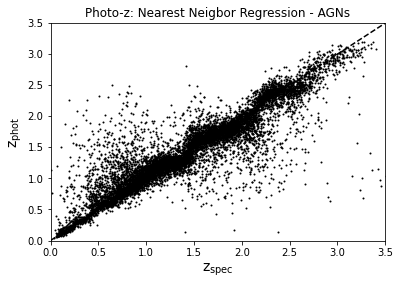

In [25]:
# Phot-Z Estimate - AGNs - kNN Estimate

x = np.vstack([np.array(r), np.array(u) - np.array(g), np.array(g) - np.array(r), np.array(r) - np.array(i), np.array(i) - np.array(z), np.array(z) - np.array(w1), np.array(w1) - np.array(w2)]).T

y = redshift

indices = np.arange(x.shape[0])

x_train, x_test, y_train, y_test, i_train, i_test = train_test_split(x, y, indices, test_size=0.10)

n_neighbors = 10

knn = KNeighborsRegressor(n_neighbors, weights='uniform')

y_pred = knn.fit(x_train,y_train).predict(x_test)

axis_lim = np.array([0.0, 3.5])
ax = plt.axes()
plt.scatter(y_test,y_pred, c='k', lw=0, s=4)
plt.plot(axis_lim, axis_lim, '--k')
plt.xlim(axis_lim)
plt.ylim(axis_lim)
plt.title('Photo-z: Nearest Neigbor Regression - AGNs')
plt.xlabel(r'$\mathrm{z_{spec}}$', fontsize=14)
plt.ylabel(r'$\mathrm{z_{phot}}$', fontsize=14)
plt.show()

In [26]:
# Phot-Z Estimate - AGNs - kNN Performance

ztest=y_test
zpred=y_pred

agn_del_z=(zpred-ztest)/(1+ztest)
agn_mean=np.mean((zpred-ztest)/(1+ztest))
agn_median=np.median((zpred-ztest)/(1+ztest))
agn_RMS=np.std((zpred-ztest)/(1+ztest))
agn_MAD=np.median(abs(agn_del_z-np.median(agn_del_z)))
agn_NMAD=1.4826*agn_MAD

print(agn_mean,agn_median,agn_RMS,agn_NMAD)

agn_sig_1 = abs(agn_del_z) > (1.*agn_RMS)
agn_sigma_1 = (float(len(agn_del_z[agn_sig_1]))/len(agn_del_z))*100.

agn_sig_2 = abs(agn_del_z) > (2.*agn_RMS)
agn_sigma_2 = (float(len(agn_del_z[agn_sig_2]))/len(agn_del_z))*100.

agn_sig_3 = abs(agn_del_z) > (3.*agn_RMS)
agn_sigma_3 = (float(len(agn_del_z[agn_sig_3]))/len(agn_del_z))*100.

agn_sig_5 = abs(agn_del_z) > 0.05
agn_sigma_5 = (float(len(agn_del_z[agn_sig_5]))/len(agn_del_z))*100.

agn_sig_10 = abs(agn_del_z) > 0.10
agn_sigma_10 = (float(len(agn_del_z[agn_sig_10]))/len(agn_del_z))*100.

agn_sig_15 = abs(agn_del_z) > 0.15
agn_sigma_15 = (float(len(agn_del_z[agn_sig_15]))/len(agn_del_z))*100.

print(agn_sigma_1,agn_sigma_2,agn_sigma_3,agn_sigma_5,agn_sigma_10,agn_sigma_15)

0.01660780482788568 0.001857757886874944 0.14388216463981815 0.05511791498980482
12.790000000000001 5.319999999999999 2.48 39.42 18.96 12.3
